# rel_pred_v001
相対座標予測

In [1]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)

In [2]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [3]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/prep/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

In [4]:
g1 = ['2020-05-14-US-MTV-1', '2020-05-14-US-MTV-2', '2020-05-21-US-MTV-1', '2020-05-21-US-MTV-2',
      '2020-05-29-US-MTV-1', '2020-05-29-US-MTV-2', '2020-06-04-US-MTV-1', '2020-06-05-US-MTV-1',
      '2020-06-05-US-MTV-2', '2020-06-11-US-MTV-1', '2020-07-08-US-MTV-1', '2020-07-17-US-MTV-1',
      '2020-07-17-US-MTV-2', '2020-08-03-US-MTV-1', '2020-08-06-US-MTV-2', '2020-09-04-US-SF-1',
      '2020-09-04-US-SF-2',  '2021-01-04-US-RWC-1', '2021-01-04-US-RWC-2',
      '2020-05-15-US-MTV-1', '2020-05-28-US-MTV-1', '2020-05-28-US-MTV-2', '2020-06-04-US-MTV-2',
      '2020-06-10-US-MTV-1', '2020-06-10-US-MTV-2', '2020-08-03-US-MTV-2', '2020-08-13-US-MTV-1',
      '2021-03-16-US-MTV-2']

g2 = ['2021-01-05-US-SVL-1', '2021-01-05-US-SVL-2', '2021-04-15-US-MTV-1', 
      '2021-03-25-US-PAO-1', '2021-04-02-US-SJC-1', '2021-04-08-US-MTV-1']

g3 = ['2021-03-10-US-SVL-1', '2021-04-26-US-SVL-1', '2021-04-26-US-SVL-2']

g4 = ['2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1', 
      '2021-03-16-US-RWC-2', '2021-04-21-US-MTV-1', '2021-04-28-US-MTV-2', '2021-04-29-US-MTV-2']

g5 = ['2021-04-22-US-SJC-1', '2021-04-28-US-SJC-1', '2021-04-29-US-SJC-2', 
      '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3']

# utils

In [5]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [6]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [7]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [8]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [9]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [10]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [11]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

In [12]:
def add_features(df):
    for c,i in itertools.product(['millisSinceGpsEpoch'], [1,2,3,4,5,-1,-2,-3,-4,-5]):
        col = c+ '_s' + str(i)
        df[col] = df[c].shift(i)
        df[col+'_diff'] = df[c] - df[col]
        df.loc[df['phone']!=df['phone'].shift(i), [col, col+'_diff']] = np.nan
    return df

In [13]:
def add_sensor_features(df, accel, gyro, mag, ori):
    # phoneを追加
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    accel['phone'] = accel['collectionName'] + '_' + accel['phoneName']
    gyro['phone'] = gyro['collectionName'] + '_' + gyro['phoneName']
    mag['phone'] = mag['collectionName'] + '_' + mag['phoneName']
    ori['phone'] = ori['collectionName'] + '_' + ori['phoneName']
    
     # 一定の値しか入っていないphoneを除外しておく
    ori = ori[~ori['phone'].isin(['2021-04-29-US-MTV-1_SamsungS20Ultra', '2021-04-28-US-MTV-1_SamsungS20Ultra', '2021-04-28-US-SJC-1_SamsungS20Ultra', '2021-04-29-US-SJC-2_SamsungS20Ultra',
                                 '2021-04-28-US-MTV-2_SamsungS20Ultra', '2021-04-29-US-SJC-3_SamsungS20Ultra', '2021-04-29-US-MTV-2_SamsungS20Ultra'])]
    
    
    # phonenameをラベルエンコーディング
    phoneName_map = {'Pixel4':1, 'Pixel4XLModded':2, 'Pixel4XL':3, 'Mi8':4, 'Pixel4Modded':5, 'Pixel5':6, 'SamsungS20Ultra':7}
    df['phoneName_le'] = df['phoneName'].map(phoneName_map)
    
    # utc -> gps
    accel['millisSinceGpsEpoch'] = accel['utcTimeMillis'] - 315964800000 + 18000
    gyro['millisSinceGpsEpoch'] = gyro['utcTimeMillis'] - 315964800000 + 18000
    mag['millisSinceGpsEpoch'] = mag['utcTimeMillis'] - 315964800000 + 18000
    ori['millisSinceGpsEpoch'] = ori['utcTimeMillis'] - 315964800000 + 18000
    
    # resampling追加
    df['secondSinceGpsEpoch'] = df['millisSinceGpsEpoch'] // 1000
    accel['secondSinceGpsEpoch'] = accel['millisSinceGpsEpoch'] // 1000
    gyro['secondSinceGpsEpoch'] = gyro['millisSinceGpsEpoch'] // 1000
    mag['secondSinceGpsEpoch'] = mag['millisSinceGpsEpoch'] // 1000
    ori['secondSinceGpsEpoch'] = ori['millisSinceGpsEpoch'] // 1000
    
    # clipping
    accel[['UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2']] = accel.groupby('phone')['UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2'].transform(lambda x: x.clip(x.quantile(0.001), x.quantile(0.999)))
    gyro[['UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec']] = gyro.groupby('phone')['UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec'].transform(lambda x: x.clip(x.quantile(0.001), x.quantile(0.999)))
    mag[['UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT']] = mag.groupby('phone')['UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT'].transform(lambda x: x.clip(x.quantile(0.001), x.quantile(0.999)))
    
    accel = accel.groupby(['phone', 'secondSinceGpsEpoch'])['UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2'].agg(['mean', 'std']).reset_index()
    accel.columns = ['phone', 'secondSinceGpsEpoch', 'UncalAccelXMps2_mean', 'UncalAccelXMps2_std', 'UncalAccelYMps2_mean', 'UncalAccelYMps2_std', 'UncalAccelZMps2_mean', 'UncalAccelZMps2_std']
    gyro = gyro.groupby(['phone', 'secondSinceGpsEpoch'])['UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec'].agg(['mean', 'std']).reset_index()
    gyro.columns = ['phone', 'secondSinceGpsEpoch', 'UncalGyroXRadPerSec_mean', 'UncalGyroXRadPerSec_std', 'UncalGyroYRadPerSec_mean', 'UncalGyroYRadPerSec_std', 'UncalGyroZRadPerSec_mean', 'UncalGyroZRadPerSec_std' ]
    mag = mag.groupby(['phone', 'secondSinceGpsEpoch'])['UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT'].agg(['mean', 'std']).reset_index()
    mag.columns = ['phone', 'secondSinceGpsEpoch', 'UncalMagXMicroT_mean', 'UncalMagXMicroT_std', 'UncalMagYMicroT_mean', 'UncalMagYMicroT_std', 'UncalMagZMicroT_mean', 'UncalMagZMicroT_std']
    ori = ori.groupby(['phone', 'secondSinceGpsEpoch'])['yawDeg', 'rollDeg', 'pitchDeg'].agg(['mean', 'std']).reset_index()
    ori.columns = ['phone', 'secondSinceGpsEpoch', 'yawDeg_mean', 'yawDeg_std', 'rollDeg_mean', 'rollDeg_std', 'pitchDeg_mean', 'pitchDeg_std']
    
    
    # shift特徴量
    for c, i in itertools.product(['UncalAccelXMps2_mean', 'UncalAccelXMps2_std', 'UncalAccelYMps2_mean', 'UncalAccelYMps2_std', 'UncalAccelZMps2_mean', 'UncalAccelZMps2_std'], [1,2,3,4,5-1,-2,-3,-4,-5]):
        col = c+ '_s' + str(i)
        accel[col] = accel[c].shift(i)
        accel[col+'_diff'] = accel[c] - accel[col]
        accel.loc[accel['phone']!=accel['phone'].shift(i), [col, col+'_diff']] = np.nan
    for c, i in itertools.product(['UncalGyroXRadPerSec_mean', 'UncalGyroXRadPerSec_std', 'UncalGyroYRadPerSec_mean', 'UncalGyroYRadPerSec_std', 'UncalGyroZRadPerSec_mean', 'UncalGyroZRadPerSec_std'], [1,2,3,4,5-1,-2,-3,-4,-5]):
        col = c+ '_s' + str(i)
        gyro[col] = gyro[c].shift(i)
        gyro[col+'_diff'] = gyro[c] - gyro[col]
        gyro.loc[gyro['phone']!=gyro['phone'].shift(i), [col, col+'_diff']] = np.nan
    for c, i in itertools.product(['UncalMagXMicroT_mean', 'UncalMagXMicroT_std', 'UncalMagYMicroT_mean', 'UncalMagYMicroT_std', 'UncalMagZMicroT_mean', 'UncalMagZMicroT_std'], [1,2,3,4,5-1,-2,-3,-4,-5]):
        col = c+ '_s' + str(i)
        mag[col] = mag[c].shift(i)
        mag[col+'_diff'] = mag[c] - mag[col]
        mag.loc[mag['phone']!=mag['phone'].shift(i), [col, col+'_diff']] = np.nan
    for c, i in itertools.product(['yawDeg_mean', 'yawDeg_std', 'rollDeg_mean', 'rollDeg_std', 'pitchDeg_mean', 'pitchDeg_std'], [1,2,3,-1,-2,-3]):
        col = c+ '_s' + str(i)
        ori[col] = ori[c].shift(i)
        ori[col+'_diff'] = ori[c] - ori[col]
        ori.loc[ori['phone']!=ori['phone'].shift(i), [col, col+'_diff']] = np.nan        
    
    df = df.merge(accel, on=['phone', 'secondSinceGpsEpoch'], how='left')
    df = df.merge(gyro, on=['phone', 'secondSinceGpsEpoch'], how='left')
    df = df.merge(mag, on=['phone', 'secondSinceGpsEpoch'], how='left')
    df = df.merge(ori, on=['phone', 'secondSinceGpsEpoch'], how='left')
    
    df.drop(['secondSinceGpsEpoch'], axis=1, inplace=True)
    
    return df

In [14]:
train, test, sub, gt = get_data()
accel_train = pd.read_csv(INPUT + '/prep/gnss/train/UncalAccel.csv')
gyro_train = pd.read_csv(INPUT + '/prep/gnss/train/UncalGyro.csv')
mag_train = pd.read_csv(INPUT + '/prep/gnss/train/UncalMag.csv')
ori_train = pd.read_csv(INPUT + '/prep/gnss/train/OrientationDeg.csv')
accel_test = pd.read_csv(INPUT + '/prep/gnss/test/UncalAccel.csv')
gyro_test = pd.read_csv(INPUT + '/prep/gnss/test/UncalGyro.csv')
mag_test = pd.read_csv(INPUT + '/prep/gnss/test/UncalMag.csv')
ori_test = pd.read_csv(INPUT + '/prep/gnss/test/OrientationDeg.csv')

train = train.merge(gt[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'speedMps']], on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
train = add_features(train)
test = add_features(test)
train = add_sensor_features(train, accel_train, gyro_train, mag_train, ori_train)
test = add_sensor_features(test, accel_test, gyro_test, mag_test, ori_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Indexing with multiple k

# doppler追加

In [15]:
def add_dop_features(df):
    for c,i in itertools.product(['d', 'roll_d', 'lat_rel', 'lng_rel', 'lat_rel_roll', 'lng_rel_roll'], [1,2,3,4,5,-1,-2,-3,-4,-5]):
        col = c+ '_s' + str(i)
        df[col] = df[c].shift(i)
        df[col+'_diff'] = df[c] - df[col]
        df.loc[df['phone']!=df['phone'].shift(i), [col, col+'_diff']] = np.nan
    return df

In [16]:
dp_train = pd.read_csv('../output/prep/doppler_processing_v004/train_result.csv')
dp_test = pd.read_csv('../output/prep/doppler_processing_v004/test_result.csv')

In [17]:
train = train.merge(dp_train, on=['phone', 'millisSinceGpsEpoch'], how='left')
test = test.merge(dp_test, on=['phone', 'millisSinceGpsEpoch'], how='left')

In [18]:
train = add_dop_features(train)
test = add_dop_features(test)

# degree追加

In [19]:
deg_train = pd.read_csv(f'../output/prep/degree_pred_v004/train_degree_pred.csv')
deg_test = pd.read_csv(f'../output/prep/degree_pred_v004/test_degree_pred.csv')

In [20]:
train = train.merge(deg_train[['phone', 'millisSinceGpsEpoch', 'calc_deg']], on=['phone', 'millisSinceGpsEpoch'], how='left')
test = test.merge(deg_test[['phone', 'millisSinceGpsEpoch', 'calc_deg']], on=['phone', 'millisSinceGpsEpoch'], how='left')

In [21]:
def add_deg_features(df):
    
    for c,i in itertools.product(['calc_deg'], [1,2,3,4,5,-1,-2,-3,-4,-5]):
        col = c+ '_s' + str(i)
        df[col] = df[c].shift(i)
        df[col+'_diff'] = df[c] - df[col]
        df.loc[df['phone']!=df['phone'].shift(i), [col, col+'_diff']] = np.nan
    
    for c in ['calc_deg']:
        df[c+'_s1_diff_sum'] = df[c+'_s1_diff'].fillna(0) + df[c+'_s-1_diff'].fillna(0)
        df[c+'_s2_diff_sum'] = df[c+'_s1_diff_sum'] + df[c+'_s2_diff'].fillna(0) + df[c+'_s-2_diff'].fillna(0)
        df[c+'_s3_diff_sum'] = df[c+'_s2_diff_sum'] + df[c+'_s3_diff'].fillna(0) + df[c+'_s-3_diff'].fillna(0)
        df[c+'_s4_diff_sum'] = df[c+'_s3_diff_sum'] + df[c+'_s4_diff'].fillna(0) + df[c+'_s-4_diff'].fillna(0)
        df[c+'_s5_diff_sum'] = df[c+'_s4_diff_sum'] + df[c+'_s5_diff'].fillna(0) + df[c+'_s-5_diff'].fillna(0)
        
    return df

In [22]:
train = add_deg_features(train)
test = add_deg_features(test)

# ラベル生成

In [23]:
gt['phone'] = gt['collectionName'] + '_' + gt['phoneName']

In [24]:
gt['lat_diff'] = gt.groupby('phone')['latDeg'].shift(-1) - gt['latDeg']
gt['lng_diff'] = gt.groupby('phone')['lngDeg'].shift(-1) - gt['lngDeg']

In [25]:
train = train.merge(gt[['phone', 'millisSinceGpsEpoch', 'lat_diff', 'lng_diff']], on=['phone', 'millisSinceGpsEpoch'], how='left')

In [26]:
train = train.dropna(subset=['lat_diff'])

# Mi8除去

In [27]:
train = train[train['phoneName']!='Mi8'].copy()
test = test[test['phoneName']!='Mi8'].copy()

In [28]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# 学習

In [29]:
target1 = 'lat_diff'
target2 = 'lng_diff'
not_use_cols = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM',
                'phone', 'speedMps', target1, target2]

features = [c for c in train.columns if c not in not_use_cols]

opt_params = {'objective': 'regression', 
              'metric': 'rmse', 
              'learning_rate': 0.1, 
              'seed': 42, 
              'feature_pre_filter': False, 
              'lambda_l1': 0.0, 
              'lambda_l2': 0.0, 
              'num_leaves': 31, 
              'feature_fraction': 0.852, 
              'bagging_fraction': 1.0, 
              'bagging_freq': 0, 
              'min_child_samples': 10, 
              'num_iterations': 20000, 
              'early_stopping_round': 100}

In [30]:
collections = train['collectionName'].unique()
oof = train[['phone', 'millisSinceGpsEpoch']].copy()
imp = pd.DataFrame()
n = len(collections)

for target in [target1, target2]:
    print(target)
    test_preds = np.zeros(len(test))
    oof1 = pd.DataFrame()

    for collection in collections:
        print('valid : ', collection)
        tr_idx = train[train['collectionName']!=collection].index
        vl_idx = train[train['collectionName']==collection].index
        tr_x, tr_y = train[features].iloc[tr_idx], train[target].iloc[tr_idx]
        vl_x, vl_y = train[features].iloc[vl_idx], train[target].iloc[vl_idx]
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(opt_params, tr_data, valid_sets=[tr_data, vl_data],
                          num_boost_round=20000, early_stopping_rounds=100, verbose_eval=100)
        vl_pred = model.predict(vl_x, num_iteration=model.best_iteration)

        oof_tmp = train.iloc[vl_idx].copy()
        oof_tmp[target] = vl_pred
        oof1 = oof1.append(oof_tmp)

        imp_tmp = pd.DataFrame()
        imp_tmp['feature'] = model.feature_name()
        imp_tmp['importance'] = model.feature_importance()
        imp_tmp['valid_collection'] = collection
        imp_tmp['target'] = target
        imp = imp.append(imp_tmp)

        pred = model.predict(test[features], num_iteration=model.best_iteration)
        test_preds += pred / n
    
    test[target] = test_preds
    oof = oof.merge(oof1[['phone', 'millisSinceGpsEpoch', target]], on=['phone', 'millisSinceGpsEpoch'], how='left')

lat_diff
valid :  2020-05-14-US-MTV-1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 143155
[LightGBM] [Info] Number of data points in the train set: 113624, number of used features: 563
[LightGBM] [Info] Start training from score 0.000006
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.25895e-06	valid_1's rmse: 1.73868e-06
[200]	training's rmse: 1.89149e-06	valid_1's rmse: 1.59402e-06
[300]	training's rmse: 1.47523e-06	valid_1's rmse: 1.55005e-06
[400]	training's rmse: 1.29202e-06	valid_1's rmse: 1.52769e-06
[500]	training's rmse: 1.17103e-06	valid_1's rmse: 1.50153e-06
[600]	training's rmse: 1.09012e-06	valid_1's rmse: 1.49504e-06
[700]	training's rmse: 1.02137e-06	valid_1's rmse: 1.48165e-06
[800]	training's rmse: 9.61979e-07	valid_1's rmse: 1.46449e-06
[900]	training's rmse: 9.08391e-07	valid_1's rmse: 1.46025e-06
[1000]	training's rmse

# 結果出力

In [31]:
gt = gt.rename(columns={'lat_diff':'lat_diff_gt', 'lng_diff':'lng_diff_gt'})
oof = gt.merge(oof, on=['phone', 'millisSinceGpsEpoch'], how='left')

In [32]:
cols = ['phone', 'millisSinceGpsEpoch', 'lat_diff', 'lng_diff']
oof[cols].to_csv(OUTPUT+'/train_result.csv', index=False)
test[cols].to_csv(OUTPUT+'/test_result.csv', index=False)

# 評価

## 特徴量重要度

In [35]:
imp

,feature,importance,valid_collection,target
0,millisSinceGpsEpoch_s1,231,2020-05-14-US-MTV-1,lat_diff
1,millisSinceGpsEpoch_s1_diff,74,2020-05-14-US-MTV-1,lat_diff
2,millisSinceGpsEpoch_s2,46,2020-05-14-US-MTV-1,lat_diff
3,millisSinceGpsEpoch_s2_diff,54,2020-05-14-US-MTV-1,lat_diff
4,millisSinceGpsEpoch_s3,35,2020-05-14-US-MTV-1,lat_diff
...,...,...,...,...
558,calc_deg_s1_diff_sum,38,2021-04-29-US-SJC-2,lat_diff
559,calc_deg_s2_diff_sum,37,2021-04-29-US-SJC-2,lat_diff
560,calc_deg_s3_diff_sum,31,2021-04-29-US-SJC-2,lat_diff
561,calc_deg_s4_diff_sum,35,2021-04-29-US-SJC-2,lat_diff


ValueError: min() arg is an empty sequence

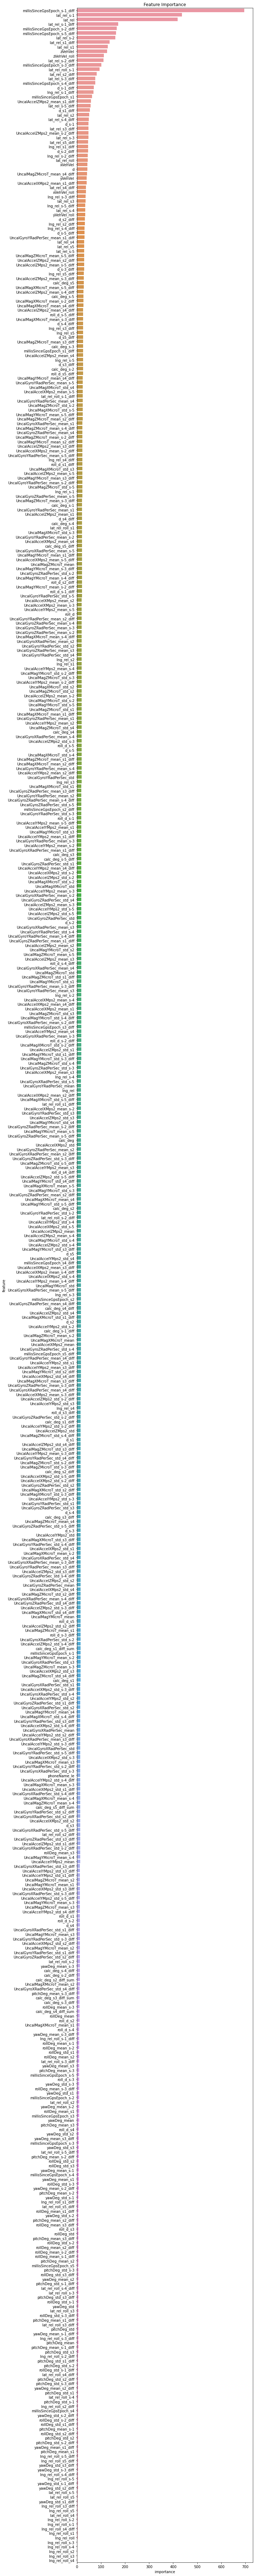

<Figure size 720x7200 with 0 Axes>

In [34]:
for target in [target1, target2]:
    imp1 = imp[imp['target']==target].copy()
    imp_mean = imp1.groupby('feature').mean().reset_index()
    plt.figure(figsize=(10, 100))
    sns.barplot(x="importance", y="feature", data=imp_mean.sort_values(by="importance", ascending=False))
    plt.title("Feature Importance")
    plt.tight_layout()

## 精度

In [36]:
from sklearn.metrics import mean_squared_error

In [37]:
oof_tmp = oof[['phone', 'lat_diff_gt', 'lng_diff_gt', 'lat_diff', 'lng_diff']].dropna()

In [38]:
print('lat_total : ', np.sqrt(mean_squared_error(oof_tmp['lat_diff_gt'], oof_tmp['lat_diff'])))
print('lng_total : ', np.sqrt(mean_squared_error(oof_tmp['lng_diff_gt'], oof_tmp['lng_diff'])))

lat_total :  1.061558819296083e-05
lng_total :  8.25101285705043e-06


## 軌跡

In [39]:
def viz(df_, outdir, train_test):
    outdir = OUTPUT + '/' + train_test + '/' + outdir
    os.makedirs(outdir, exist_ok=True)
    df = df_.copy()
    
    for phone in df['phone'].unique():
        tmp = df[df['phone']==phone].copy()

        fig, axes = plt.subplots(figsize=(40, 15), nrows=2, sharex=True)
        axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['lat_diff'], label='lat_diff')
        axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['lng_diff'], label='lng_diff')
        
        if train_test == 'train':
            axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['lat_diff_gt'], label='lat_diff_gt')
            axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['lng_diff_gt'], label='lng_diff_gt')
        
        axes[0].legend(loc='upper right')
        axes[0].grid(color='g', linestyle=':', linewidth=0.3)
        axes[1].legend(loc='upper right')
        axes[1].grid(color='g', linestyle=':', linewidth=0.3)

        fig.suptitle(phone, fontsize=16)
        fig.savefig(f'{outdir}/{phone}.png')
        plt.close()

In [40]:
viz(oof, 'diff_pred', 'train')
viz(test, 'diff_pred', 'test')